# Mobility Controller Module


Our project discusses about a design that can smartly control overcrowding of people in popular places without prohibiting people’s mobility. Our primary responsibilities is to try “flattening the curve”.
<br>
The main project has been divided into four components - Spatial Mobility Model (SMM), Epidemiological Model (EMM), the Agent Based Modeling (ABM), the Mobility Controller (ours). 
1.	Mobility Model - Read in mobility data and generate spatial model of NYC and simulate trips that people might take.
<br>
2. Agent Based Model Simulation - Receive sample trips from mobility model and maintain state of citizens taking trips (sick, healthy, etc.) which will come from epidemiological model.
<br>
3. Epidemiological Model - Models agents and movements with regards to health/sickness under variety of simulations to explore strategies of "flattening the curve".
<br>
4. Mobility Controller - Receives booking requests from agent-based model simulation and ultimately decides whether or not a trip is safe to make. Confirmation/rejection is passed to agent-based model simulation. Also an alternative time will be given if that block reached maximum capacity. Also our policy should be fair to all agents - no agent should be allowed to cheat and receive consecutive booking confirmations. 

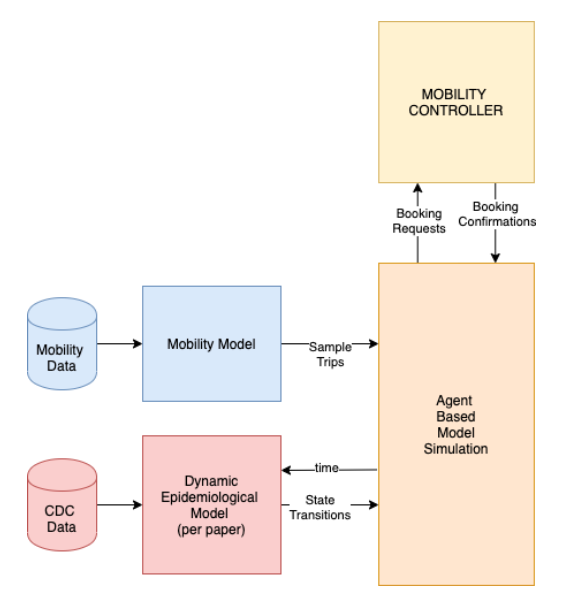

In [ ]:
#image from project page 
from IPython.display import Image
PATH_IMAGE = "/content/drive/My Drive/Colab Notebooks/NYC_sim_/projectpage.png"
Image(filename=PATH_IMAGE) 

### Interfaces 
We use practically batch datasets. 
As input we are using a generic simulation.csv file. It is a daily file. What it means, it is one day of request and cancelations, it has only the hour. It has a small limitation: If the slot 23 is full, booking must go into next day batch file. Also we can not check in this process if the person that is booking for hour zero has already booked in the previous day. We listed this issue in the to do list as possible future task for later groups and if the process becomes on line that will be adressed much easier.
<br> Simulation.csv Fields:
<br>hour - desire time
<br>pickup_grid_number - a block from a list of 2500
<br>dropoff_grid_number - a block from a list of 2500
<br>user_id - agent id
<br>state - generic fields, we selected states in the follewing way. 0 is used as booking,  1 as cancelation and we ignore the rest
<br>
As output we have a confirmation.csv file.
<br>Confirmation.csv Fields:
<br>code - 0 for allowed, 1 for rebooked, -1 for denied, -2 for when the 23rd slot is full (limitation), and -3 cancelled booking. File is per day.
<br>agent_id 
<br>hour - n ∈ [0,23] when trip was allowed, -1 no assigned time, and 25 must go in next day (another file). 




### Methodology
To guide us we followed Professor Pantelis comments: “The human density you have across Manhattan can be represented as a sequence of matrices across time (1h intervals is giving you 24 matrices). You have matrices that one zone is a hotspot in some and others that are not even if your policy is “do nothing”. So lets assume now that you have a model and you draw trips from then a sufficient simulation interval of 1h you will be matching the raw data you model considered to begin with for that interval. For that 1h interval the controller lets assume that does *not* know the model and therefore cant a priori design a policy. There are controllers that are model-based but lets not go there in this project. The only thing that it will do then, it will start accepting all trips initially until a certain level of number of drop offs (maximum number of bookings for the destination also known as capacity threshold) and it will rebook the trip to another time slot confirming it for that slot only. The rebooking may cause the agent to cancel the confirmed rebooked trip. The state that you keep is the booking and rebookings you have confirmed minus the cancellations so you know your leftover capacity.”  

###Structures and constants



#### Internal structures
Simulation dataset has been reduced to 2500 blocks (geographical locations) for practicality purposes. We could even use the 260 Manhattan blocks but each one has a geographical locations. We have a vector of 2500 positions that contains the threshold per block. Some blocks will have the threshold "DO_NOTHING_BLOCK". The other structure is 3D, a combination of an array of 2500x24 hours and a list of users.
#### Constants:
BOOKING = 0
<br>NBLOCK = 2500
<BR>CANCELATION = 1
<BR>ALLOWED = 0 
<BR>REBOOKED = 1
<BR>DENIED = -1
<BR>DAY_IS_FULL = -2
<BR>CANCELLED_BOOKING = -3
<BR>NEXT_DAY_HOUR_CODE = 25
<BR>NO_ASSIGN_HOUR = -1
<br>DO_NOTHING_BLOCK = 0
<br>PATH_INPUT (must be adjusted according to the environment)
<br>PATH_OUTPUT (must be adjusted according to the environment)
<br>PATH_INPUT_check (must be adjusted according to the environment)

In [ ]:
import numpy as np
import pandas as pd
import math

In [ ]:
# We will use a general simulation file named simulation.csv
# we will extract the information we need from it and format the data to
# our purposes. The simulation file is a daily file as you will see. It only
# has the hour for time. It has a small limitation: If the slot 23 is full, booking must go into 
# next day batch file. Also we can not check in this process if the person who is booking for hour zero 
# has already booked in the previous day.  This issue will be overcome in a 
# online system
PATH_INPUT = "/content/drive/My Drive/Colab Notebooks/NYC_sim_/simulation.csv"
df = pd.read_csv(PATH_INPUT)
NBLOCK=2500


In [ ]:
print(df.dtypes)
print(df.describe())
df.shape

hour                     int64
pickup_grid_number     float64
dropoff_grid_number    float64
user_id                  int64
state                  float64
dtype: object
               hour  pickup_grid_number  ...       user_id         state
count  4.044144e+06        4.044144e+06  ...  4.044144e+06  4.044144e+06
mean   1.359588e+01        3.560740e+02  ...  2.022072e+06  2.999997e-01
std    6.457568e+00        2.751702e+02  ...  1.167444e+06  6.403123e-01
min    0.000000e+00        1.000000e+00  ...  0.000000e+00  0.000000e+00
25%    9.000000e+00        1.440000e+02  ...  1.011036e+06  0.000000e+00
50%    1.400000e+01        2.970000e+02  ...  2.022072e+06  0.000000e+00
75%    1.900000e+01        5.000000e+02  ...  3.033107e+06  0.000000e+00
max    2.300000e+01        2.500000e+03  ...  4.044143e+06  2.000000e+00

[8 rows x 5 columns]


(4044144, 5)

In [ ]:
# convert fields to integer as needed
# simulation file has data for other groups; 
# so we remove it in here too
df = df[df.state<2]
df = df.iloc[::5, :]
df["state"] = df["state"]. astype(int)
df["pickup_grid_number"] = df["pickup_grid_number"]. astype(int)
df["dropoff_grid_number"] = df["dropoff_grid_number"]. astype(int)


In [ ]:
print(df.dtypes)
print(df.describe())
print(df.shape)

hour                   int64
pickup_grid_number     int64
dropoff_grid_number    int64
user_id                int64
state                  int64
dtype: object
                hour  pickup_grid_number  ...       user_id          state
count  727946.000000       727946.000000  ...  7.279460e+05  727946.000000
mean       13.595893          355.876735  ...  2.022027e+06       0.111305
std         6.457161          275.336569  ...  1.167379e+06       0.314510
min         0.000000            1.000000  ...  0.000000e+00       0.000000
25%         9.000000          144.000000  ...  1.011196e+06       0.000000
50%        14.000000          296.000000  ...  2.021883e+06       0.000000
75%        19.000000          504.000000  ...  3.033110e+06       0.000000
max        23.000000         2500.000000  ...  4.044139e+06       1.000000

[8 rows x 5 columns]
(727946, 5)


In [ ]:
df.head()

,hour,pickup_grid_number,dropoff_grid_number,user_id,state
0,0,115,60,0,0
5,0,533,312,5,0
10,0,264,144,10,1
15,0,152,21,15,0
20,0,308,18,20,0


In [ ]:
df.tail()

,hour,pickup_grid_number,dropoff_grid_number,user_id,state
4044116,23,78,504,4044116,0
4044121,23,36,198,4044121,0
4044126,23,234,520,4044126,1
4044132,23,160,1349,4044132,0
4044139,23,300,799,4044139,0


In [ ]:
# Let's sort array per hour then by state
df.sort_values(by=['hour', 'state'])

,hour,pickup_grid_number,dropoff_grid_number,user_id,state
0,0,115,60,0,0
5,0,533,312,5,0
15,0,152,21,15,0
20,0,308,18,20,0
26,0,182,408,26,0
...,...,...,...,...,...
4043826,23,42,104,4043826,1
4043880,23,342,100,4043880,1
4043894,23,261,1037,4043894,1
4044111,23,550,672,4044111,1


In [ ]:
# structure is a cobination of 2d array + lists.
block_hour = np.empty((NBLOCK,24),dtype=np.ndarray)
for i in range(NBLOCK):
    for j in range(24):
      block_hour[i][j]=[]

In [ ]:
# we need to assign random thresholds for each block. 
DO_NOTHING_BLOCK = 0
threshold = np.random.randint(low=0, high=len(df)/NBLOCK, size=(NBLOCK))
threshold[np.random.randint(1,NBLOCK,size=int(NBLOCK/2))] = DO_NOTHING_BLOCK

In [ ]:
# manhattan dimentions is 13.4 miles length and 2.3 miles width, the biggest distance is its diagonal
c = int(math.sqrt(13.4**2 + 2.3**2))


In [ ]:
BOOKING = 0
CANCELATION = 1
ALLOWED = 0
REBOOKED = 1
DENIED = -1
DAY_IS_FULL = -2
CANCELLED_BOOKING = -3
NEXT_DAY_HOUR_CODE = 25
NO_ASSIGN_HOUR = -1
codes=[]
ids=[]
hours=[]
# we will be looking only a dropoff for controlling mobility
for index, row in df.iterrows():
    dropoff_grid_number = row["dropoff_grid_number"] - 1
    if (threshold[dropoff_grid_number]== DO_NOTHING_BLOCK):  
        continue
    # fake distance, the blocks do not reflex any geographical positions; 
    # we may as well use a random generator to get the detached distance
    d = np.random.uniform(0,c)
    if (d <= 1):
        continue
    if (row['state']==CANCELATION):
        if (len(block_hour[dropoff_grid_number][row["hour"]]) != 0):
            if row["user_id"] in block_hour[dropoff_grid_number][row["hour"]]:
                block_hour[dropoff_grid_number][row["hour"]].remove(row["user_id"])
                codes.append(CANCELLED_BOOKING)
                ids.append(row["user_id"]) 
                hours.append(NO_ASSIGN_HOUR) 
               
    elif (row['state']==BOOKING):
        if (row["hour"]!=0):
            # check if there is no consecutive booking requisicions
            if row["user_id"] in block_hour[dropoff_grid_number][row["hour"]-1]:
                codes.append(DENIED)
                ids.append(row["user_id"]) 
                hours.append(NO_ASSIGN_HOUR) 
                continue
        # check if it was already booked, allowed but do not add it in structure list         
        if row["user_id"] in block_hour[dropoff_grid_number][row["hour"]]:
            codes.append(ALLOWED)
            ids.append(row["user_id"]) 
            hours.append(row["hour"]) 
            continue

        code = DAY_IS_FULL
        for h in range(row["hour"],24):
            if (len(block_hour[dropoff_grid_number][h]) < 
                      threshold[dropoff_grid_number]):
                (block_hour[dropoff_grid_number][h]).append (row["user_id"])
                if (h == row["hour"]):
                  code = ALLOWED
                else:
                  code = REBOOKED 
                codes.append(code)
                ids.append(row["user_id"])
                hours.append(h)
                break
        if (code==DAY_IS_FULL): 
            codes.append(code)
            ids.append(row["user_id"])
            hours.append(NEXT_DAY_HOUR_CODE)          
    else:
        continue
                                        
    

In [ ]:

PATH_OUTPUT = "/content/drive/My Drive/Colab Notebooks/NYC_sim_/confirmations.csv"


df_out = pd.DataFrame(codes, columns=['code'])
df_out['agent_id'] = ids
df_out['hour'] = hours
df_out[['code','agent_id','hour']].to_csv((PATH_OUTPUT), index=False)
print('output done')


output done


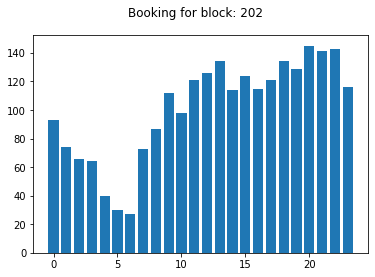

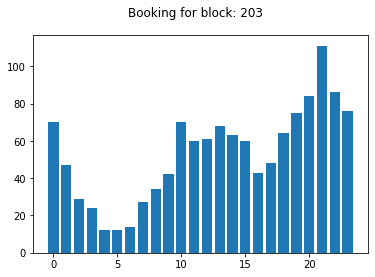

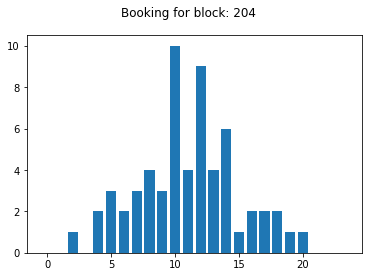

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
#example: bookings per block, posible useful graphs
x = np.zeros(24)
num_bins=24

names = range(0,24)
for i in range(201,205):
    if threshold[i] !=0:
        for j in range(24):
            x[j]=len(block_hour[i][j])
 

        plt.subplot()
        plt.bar(names, x)
        plt.suptitle('Booking for block: ' + str(i))
        plt.show()


#### Self check section
To verify if file was created and fields are in order

In [ ]:
PATH_INPUT_check = "/content/drive/My Drive/Colab Notebooks/NYC_sim_/confirmations.csv"
df_check = pd.read_csv(PATH_INPUT_check)


In [ ]:
df_check.head()

,code,agent_id,hour
0,0,0,0
1,0,5,0
2,0,15,0
3,0,20,0
4,0,26,0


In [ ]:
df_check.tail()

,code,agent_id,hour
382554,0,4044061,23
382555,-2,4044083,25
382556,-2,4044101,25
382557,-2,4044106,25
382558,0,4044132,23


In [ ]:
print(df_check.shape)

(382559, 3)


#### Things to do (for new groups):
- We started to code in Python this year; the code can be improved for performance and elegance too.
- The system should run a connected schedule between days in real life, more than just one day. 
- System should be made online instead of batch.
- The file that we are using is a general purpose simulation file for other group projects too; each user_id is only once in the file; so keys of cancellations are not fully tested for tracing back previous booking but code has a validation to check if the agent_id exists before removing cancelation.
- We could also make use of pickups and basic population to have a complete idea of the population
- To use real latitude and longitude; then  we can also get the distance in miles or use geo blocks. 
- More visuals
- Blocks could be added to output



Reference: Some comments in the notebook comes from the project page and the professor.
